## The grid cell system model is a spiking neural network (SNN) model written in pyNEST (2.18)
@author R Stentiford

In this experiment a grid cell attractor network is built using interactions between and excitatory and inhibitory population. Four conjunctive layers driven by the translational velocity drive the activity bump across the sheet

A constant velocity spiral is used to observe the griddiness of these network parameters

Three of each nessesary populaiton are used and the parameter 'base_cj' is varied tp produce 3 sizes of grid fields.

A single place cell is also defined which recieved input from 3 grid cells. In the place where the grid fields overlap the PC will recieve input from all three grid cells and fire producing a place field

IN THIS EXAMPLE SPIKES ARE SAVED TO FILE 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import pandas as pd
from datetime import datetime
import os

sim.ResetKernel()

#save experiment with the time
tic = tm.time()
txt = str(datetime.now())
spl = txt.split(' ')
spl2 = spl[1].split('.')
txt = f'{spl[0]}_{spl2[0]}'
file = f'{txt}_spikes'
chunk = 10000
folder = f'3_scales/{txt}'
os.makedirs(folder)
sim.SetKernelStatus({"overwrite_files": True,"data_path": folder,"data_prefix": txt})

mins = .5 #3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 0.5 mins = 30000 ms


### Params

In [2]:
y_dim = (0.5* np.sqrt(3))
Nx = 20
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny

sigma = 0.5/6 #0.12
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
cj_1 = 2000. #1100.
cj_2 = 3000.
cj_3 = 4000.
w_ex_cj = 500.

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 350

### Create populations

All cells are simulated using pyNEST's standard leaky integrate-and-fire neuron model (iaf_psc_alpha) which uses alpha-function shaped synaptic currents. 

Each network is composed of six equally sized rings of neurons: 180 excitatory cells, 180 excitatory cells, 180 of each up, down, left and right conjunctive cells. 

Three networks are defined, each will have a different grid spacing.

Constant input current of 400 pA to all excitatory neurons results in spontaneous firing.

In [3]:
exc_1 = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
exc_2 = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
exc_3 = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})

inh_1 = sim.Create("iaf_psc_alpha",N)
inh_2 = sim.Create("iaf_psc_alpha",N)
inh_3 = sim.Create("iaf_psc_alpha",N)

l_1 = sim.Create("iaf_psc_alpha",N)
r_1 = sim.Create("iaf_psc_alpha",N)
u_1 = sim.Create("iaf_psc_alpha",N)
d_1 = sim.Create("iaf_psc_alpha",N)
l_2 = sim.Create("iaf_psc_alpha",N)
r_2 = sim.Create("iaf_psc_alpha",N)
u_2 = sim.Create("iaf_psc_alpha",N)
d_2 = sim.Create("iaf_psc_alpha",N)
l_3 = sim.Create("iaf_psc_alpha",N)
r_3 = sim.Create("iaf_psc_alpha",N)
u_3 = sim.Create("iaf_psc_alpha",N)
d_3 = sim.Create("iaf_psc_alpha",N)

PC = sim.Create("iaf_psc_alpha",1)

### Define connections

Attractor dynamics emerge through reciprocal connections between cells in the excitatory population and inhibitory population. Each excitatory cell connects to a subset of inhibitory neurons with declining synaptic strength as a function of distance. Reciprocal inhibitory connections from each inhibitory cell to excitatory cells are arranged with synaptic strength decreasing as a function of distance offset by a constant (mu).

This arrangement provides inhibitory input to the cells surrounding the most active excitatory cell, producing a single stable bump of activity.

Cells are arranged as 2D sheets with twisted torus wrap around connectivity for the purpose of defining synaptic strength based on distance. See Guanella et al 2007 for a full description of this connectivity structure and the origin of the following calculations.

In [4]:
def twistedTorus(x_e,y_e,x_i,y_i,y_dim):
        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d7 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        
        return min(d1,d2,d3,d4,d5,d6,d7)

In [5]:
w_ex = np.empty((N,N))
w_in = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = y_dim*(e//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny
        
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)

        w_gauss = np.exp(-(d_)**2/2/sigma**2)
        w_ring = np.exp(-(d_ - mu)**2/2/sigma**2)

        w_ex[i,e] = base_ex * w_ring
        w_in[e,i] = base_in * w_gauss

w_ex[w_ex<10]=0
w_in[w_in<10]=0

In order to track translaiton based on velocity the four populations of conjunctive cells are connected one to one with an excitatory cell, shifted one cell u, down, left or right on the sheet from the equivalently positioned neuron.

The same distance dependent calculation is performed, using ofset positions of the inhibitory cell, with only the strongest connection maintained. Due to the twisted torus configuration and the ydim parameter this may be more than one cell with lower weights.

In [6]:
w_l = np.empty((N,N))
w_r = np.empty((N,N))
w_u = np.empty((N,N))
w_d = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx) / Ny * y_dim
    for i in range(N): 
        x_i = ((i%Nx) / Nx) - (1/Nx) #shift
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_l[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = ((i%Nx) / Nx) + (1/Nx) #shift 
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_r[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))        

        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) + (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_u[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) - (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_d[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0
m = np.amax(w_u)
w_u[w_u<m] = 0
m = np.amax(w_d)
w_d[w_d<m] = 0

In [6]:
sim.Connect(exc_1,inh_1,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
sim.Connect(inh_1,exc_1,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})
sim.Connect(exc_2,inh_2,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
sim.Connect(inh_2,exc_2,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})
sim.Connect(exc_3,inh_3,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
sim.Connect(inh_3,exc_3,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

sim.Connect(exc_1,l_1,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_1,r_1,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_1,u_1,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_1,d_1,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_2,l_2,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_2,r_2,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_2,u_2,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_2,d_2,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_3,l_3,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_3,r_3,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_3,u_3,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc_3,d_3,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

sim.Connect(l_1,exc_1,'all_to_all',syn_spec={'weight': w_l *cj_1, 'delay': delay})
sim.Connect(r_1,exc_1,'all_to_all',syn_spec={'weight': w_r *cj_1, 'delay': delay})
sim.Connect(u_1,exc_1,'all_to_all',syn_spec={'weight': w_u *cj_1, 'delay': delay})
sim.Connect(d_1,exc_1,'all_to_all',syn_spec={'weight': w_d *cj_1, 'delay': delay})
sim.Connect(l_2,exc_2,'all_to_all',syn_spec={'weight': w_l *cj_2, 'delay': delay})
sim.Connect(r_2,exc_2,'all_to_all',syn_spec={'weight': w_r *cj_2, 'delay': delay})
sim.Connect(u_2,exc_2,'all_to_all',syn_spec={'weight': w_u *cj_2, 'delay': delay})
sim.Connect(d_2,exc_2,'all_to_all',syn_spec={'weight': w_d *cj_2, 'delay': delay})
sim.Connect(l_3,exc_3,'all_to_all',syn_spec={'weight': w_l *cj_3, 'delay': delay})
sim.Connect(r_3,exc_3,'all_to_all',syn_spec={'weight': w_r *cj_3, 'delay': delay})
sim.Connect(u_3,exc_3,'all_to_all',syn_spec={'weight': w_u *cj_3, 'delay': delay})
sim.Connect(d_3,exc_3,'all_to_all',syn_spec={'weight': w_d *cj_3, 'delay': delay})

#connect one cell from each grid network to the place cell
sim.Connect([exc_1[I_init_pos]],PC,'one_to_one',syn_spec={'weight': 80, 'delay': delay})
sim.Connect([exc_2[I_init_pos]],PC,'one_to_one',syn_spec={'weight': 80, 'delay': delay})
sim.Connect([exc_3[I_init_pos]],PC,'one_to_one',syn_spec={'weight': 80, 'delay': delay})

### Network input

In order to observe the gridy firing properties of these cells without problems such as drift, a constant velocity spiral is used to get high coverage of a circular arena.

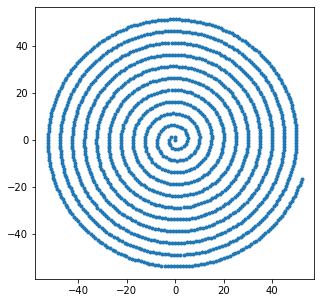

In [7]:
number_of_turns = 20
numT = number_of_turns * 1000 * np.pi
dt = 20
t = np.arange(0,sim_len,dt)*1.
time = [i * 1. for i in t if i < sim_len]
ts = np.arange(0,numT,numT/len(t))/1000.
V = 30
dr = 5
ph = np.sqrt(((V * (4*np.pi) * ts) / dr))
ra =  np.sqrt(((V * dr * ts) / np.pi))

fig = plt.figure(figsize=(5, 5),facecolor='w')
pos_x = ra * np.cos(ph) 
pos_y = ra * np.sin(ph)
plt.plot(pos_x,pos_y,'.')

Positive x values indicate leftwards head movements and are funneled to go_l and negative x values indicate rightwards head movements and are funneled to go_r. Positive y values indicate upwards head movements and are funneled to go_u and negative y values indicate downwards head movements and are funneled to go_d

We map the 'velocity' to a range of currents which produce the expected movement across the sheet. A step current generator supplies this current to the respective conjunctive cell population.

In [9]:
vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)
vel_x,vel_y = vel_x*3500, vel_y*3500

sh = 150
go_l,go_r = vel_x,-vel_x
go_u,go_d = vel_y,-vel_y
go_l, go_r, go_u, go_d = go_l+sh, go_r+sh, go_u+sh, go_d+sh
go_l[go_l<=sh] = 0.
go_r[go_r<=sh] = 0.
go_u[go_u<=sh] = 0.
go_d[go_d<=sh] = 0.

l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})
u_input = sim.Create('step_current_generator', 1)
sim.SetStatus(u_input,{'amplitude_times': t[1:],'amplitude_values': go_u})
d_input = sim.Create('step_current_generator', 1)
sim.SetStatus(d_input,{'amplitude_times': t[1:],'amplitude_values': go_d})

In [10]:
sim.Connect(l_input,l_1,'all_to_all')
sim.Connect(r_input,r_1,'all_to_all')
sim.Connect(u_input,d_1,'all_to_all')
sim.Connect(d_input,u_1,'all_to_all')
sim.Connect(l_input,l_2,'all_to_all')
sim.Connect(r_input,r_2,'all_to_all')
sim.Connect(u_input,d_2,'all_to_all')
sim.Connect(d_input,u_2,'all_to_all')
sim.Connect(l_input,l_3,'all_to_all')
sim.Connect(r_input,r_3,'all_to_all')
sim.Connect(u_input,d_3,'all_to_all')
sim.Connect(d_input,u_3,'all_to_all')

### Record spikes

In [11]:
exc_spikes_1 = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "gc_spikes_1"})
sim.Connect([exc_1[I_init_pos]],exc_spikes_1)
exc_spikes_2 = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "gc_spikes_2"})
sim.Connect([exc_2[I_init_pos]],exc_spikes_2)
exc_spikes_3 = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "gc_spikes_3"})
sim.Connect([exc_3[I_init_pos]],exc_spikes_3)
pc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "pc_spikes"})
sim.Connect(PC,pc_spikes)

### Init bump

In [12]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc_1[I_init_pos]])
sim.Connect(bump_init,[exc_2[I_init_pos]])
sim.Connect(bump_init,[exc_3[I_init_pos]])

### Run simulation

In [13]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)}s  Simulated time: {np.around(sim_len/1000,2)}s')

In [15]:
num = 1
for file in os.listdir(folder):
    if file.endswith(".gdf"):
        data = pd.read_csv(f'{folder}/{file}', delimiter="\t")
        data = data.drop(columns=['Unnamed: 2'])
        data = data.set_axis(['sp','t'], axis=1, inplace=False)
        sp = np.array(data['sp'])
        t = np.array(data['t'])
        
        occurence_count = Counter(sp) 

        cell = occurence_count.most_common(5)[0][0]
        print(cell)

        spktms = t[sp==cell]
        spktms = (spktms//20)*20
        spktms=spktms[1:]

        xs = np.empty((len(spktms)))
        ys = np.empty((len(spktms)))

        for i,spk in enumerate(spktms):
            xs[i] = pos_x[np.where(time == spk)[0][0]]
            ys[i] = pos_y[np.where(time == spk)[0][0]]

        fig = plt.figure(figsize=(5, 5),facecolor='w')
        plt.plot(pos_x[:len(time)],pos_y[:len(time)])
        plt.plot(xs,ys,'.')
        file = file.split('.')
        plt.savefig(f'{folder}/{file[0]}.png')

351.0


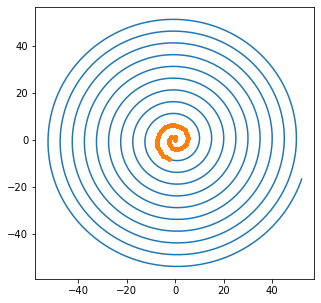

711.0


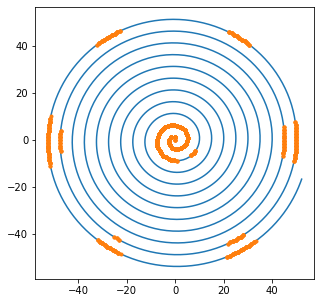

1071.0


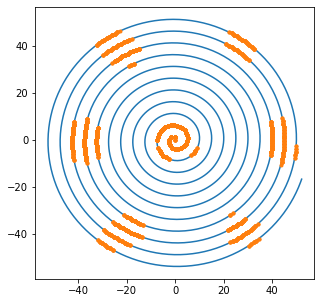

6481.0


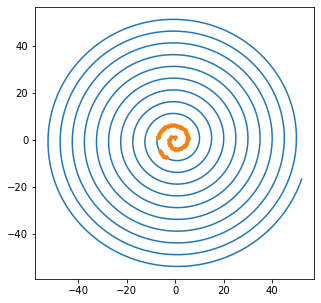